In [1]:
pip install tensorflow


  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4847 sha256=2cf9b71cbfa65763faddebda6e84cf0384fbe6484cd70ce079ca879ca0efa648
  Stored in directory: c:\users\byron\appdata\local\pip\cache\wheels\b6\0d\90\0d1bbd99855f99cb2f6c2e5ff96f8023fad8ec367695f7d72d
Successfully built termcolor


In [2]:
import os
import pathlib
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image, ImageOps
from IPython.display import display
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

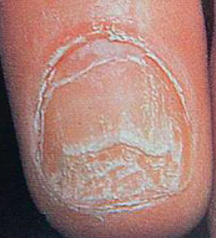

In [3]:
src_img = Image.open('E:/4th year/Thesis/Datasets/nail pitting/4.png')
display(src_img)

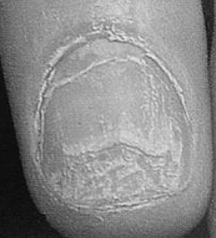

In [4]:
gray_img = ImageOps.grayscale(src_img)
display(gray_img)

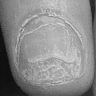

In [5]:
gray_resized_img = gray_img.resize(size=(96, 96))
display(gray_resized_img)

In [6]:
np.ravel(gray_resized_img)

array([100, 103, 102, ...,  64,  85,  95], dtype=uint8)

In [7]:
img_final = np.ravel(gray_resized_img) / 255.0
img_final

array([0.39215686, 0.40392157, 0.4       , ..., 0.25098039, 0.33333333,
       0.37254902])

In [8]:
def process_image(img_path: str) -> np.array:
    img = Image.open(img_path)
    img = ImageOps.grayscale(img)
    img = img.resize(size=(96, 96))
    img = np.ravel(img) / 255.0
    return img

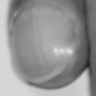

In [9]:
tst_img = process_image(img_path='E:/4th year/Thesis/Datasets/clubbing/1.png')
Image.fromarray(np.uint8(tst_img * 255).reshape((96, 96)))

In [10]:
def process_folder(folder: pathlib.PosixPath) -> pd.DataFrame:
    # We'll store the images here
    processed = []
    
    # For every image in the directory
    for img in folder.iterdir():
        # Ensure JPG
        if img.suffix == '.jpg':
            # Two images failed for whatever reason, so let's just ignore them
            try:
                processed.append(process_image(img_path=str(img)))
            except Exception as _:
                continue
           
    # Convert to pd.DataFrame
    processed = pd.DataFrame(processed)
    # Add a class column - dog or a cat
    processed['class'] = folder.parts[-1]
    
    return processed

In [11]:
# Training set
train_nail_pitting = process_folder(folder=pathlib.Path.cwd().joinpath('E:/4th year/Thesis/Datasets/train_nailpitting'))
train_clubbing = process_folder(folder=pathlib.Path.cwd().joinpath('E:/4th year/Thesis/Datasets/train_clubbing'))
train_set = pd.concat([train_nail_pitting, train_clubbing], axis=0)

with open('train_set.pkl', 'wb') as f:
    pickle.dump(train_set, f)

# Test set
test_nail_pitting = process_folder(folder=pathlib.Path.cwd().joinpath('E:/4th year/Thesis/Datasets/test_nailpitting'))
test_clubbing = process_folder(folder=pathlib.Path.cwd().joinpath('E:/4th year/Thesis/Datasets/test_clubbing'))
test_set = pd.concat([test_nail_pitting, test_clubbing], axis=0)

with open('test_set.pkl', 'wb') as f:
    pickle.dump(test_set, f)

# Validation set 
valid_nail_pitting = process_folder(folder=pathlib.Path.cwd().joinpath('E:/4th year/Thesis/Datasets/validation_nailpitting'))
valid_clubbing = process_folder(folder=pathlib.Path.cwd().joinpath('E:/4th year/Thesis/Datasets/validation_clubbing'))
valid_set = pd.concat([valid_nail_pitting, valid_clubbing], axis=0)

with open('valid_set.pkl', 'wb') as f:
    pickle.dump(valid_set, f)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'E:\\4th year\\Thesis\\Datasets\\train_nailpitting'

In [ ]:
train_set = shuffle(train_set).reset_index(drop=True)
valid_set = shuffle(valid_set).reset_index(drop=True)

In [ ]:
X_train = train_set.drop('class', axis=1)
y_train = train_set['class']

X_valid = valid_set.drop('class', axis=1)
y_valid = valid_set['class']

X_test = test_set.drop('class', axis=1)
y_test = test_set['class']

In [ ]:
y_train.factorize()

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train.factorize()[0], num_classes=2)
y_valid = tf.keras.utils.to_categorical(y_valid.factorize()[0], num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test.factorize()[0], num_classes=2)

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_valid, y_valid)
)

In [ ]:
plt.plot(np.arange(1, 101), history.history['loss'], label='Training Loss')
plt.plot(np.arange(1, 101), history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

In [ ]:
plt.plot(np.arange(1, 101), history.history['accuracy'], label='Training Accuracy')
plt.plot(np.arange(1, 101), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();